# Figures

In [3]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig1 = plt.figure(figsize=(7, 6.6), dpi=600, facecolor="None")

fig1 = plt.figure(figsize=(13, 12), dpi=600)
gs1 = GridSpec(2, 2, fig1)

ax00 = fig1.add_subplot(gs1[0, 0])
ax01 = fig1.add_subplot(gs1[0, 1])
ax10 = fig1.add_subplot(gs1[1, 0])
ax11 = fig1.add_subplot(gs1[1, 1])

# ax00.set_aspect("equal")
# ax01.set_aspect("equal")
# ax002.set_aspect("equal")

fig1.tight_layout()

<Figure size 4200x3960 with 0 Axes>

## Figure 1

In [59]:
import pandas as pd
from scipy import stats
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from Checkpoints import Checkpoint
from graphing import *
import numpy as np

##### Fig1 #####
sns.set_style("whitegrid")
sns.set_palette("crest")

fig1 = plt.figure(figsize=(12, 11), dpi=600)
gs1 = GridSpec(2, 2, fig1)

##### ax00 ##### 

ax00 = fig1.add_subplot(gs1[0, 0])

if not "two_mod_wide" in locals():
    two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()

ax00.set_aspect("equal")
div00 = make_axes_locatable(ax00)
cax00 = div00.append_axes("right", size="5%", pad=0.05)
sns.histplot(two_mod_wide, x="percentMeth_WGBS", y="percentMeth_Nanopore", 
             bins=20, pthresh=0.01, stat="proportion", cbar=True, cbar_kws={"label" : "Proportion"}, cbar_ax=cax00, ax=ax00)

ax00.set_xlim((0, 100))
ax00.set_ylim((0, 100))
ax00.set_xlabel("WGBS \u03B2$_{\%}$")
ax00.set_ylabel("Nanopore \u03B2$_{\%}$")
ax00.set_title("A", loc="left")

##### ax01 ##### 

ax01 = fig1.add_subplot(gs1[0, 1])

if not "mc_df_wide" in locals():
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()

ax01.set_aspect("equal")
div01 = make_axes_locatable(ax01)
cax01 = div01.append_axes("right", size="5%", pad=0.05)
sns.histplot(mc_df_wide, x="percentMeth_oxBS_5mC", y="percentMeth_Nanopore_5mC", 
             bins=20, pthresh=0.01, stat="proportion", cbar=True, cbar_kws={"label" : "Proportion"}, cbar_ax=cax01, ax=ax01)

ax01.set_xlim((0, 100))
ax01.set_ylim((0, 100))
ax01.set_xlabel("oxBS \u03B2$_{\%}$")
ax01.set_ylabel("Nanopore \u03B2$_{\%}$")
ax01.set_title("B", loc="left")
ax01.xaxis.set_major_locator(MultipleLocator(20))

##### ax10 ##### 

if not "hmc_df_wide" in locals():
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

ax10 = fig1.add_subplot(gs1[1, 0])

ax10.set_aspect("equal")
div10 = make_axes_locatable(ax10)
cax10 = div10.append_axes("right", size="5%", pad=0.05)
sns.histplot(hmc_df_wide, x="percentMeth_TAB_5hmC", y="percentMeth_Nanopore_5hmC", 
             bins=20, pthresh=0.01, stat="proportion", cbar=True, cbar_kws={"label" : "Proportion"}, cbar_ax=cax10, ax=ax10)

ax10.set_xlim((0, 100))
ax10.set_ylim((0, 100))
ax10.set_xlabel("TAB \u03B2$_{\%}$")
ax10.set_ylabel("Nanopore \u03B2$_{\%}$")
ax10.set_title("C", loc="left")
ax10.xaxis.set_major_locator(MultipleLocator(20))

##### ax11 ##### 

ax11 = fig1.add_subplot(gs1[1, 1])

ax11.set_aspect("equal")
ax11.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "black", linestyle=":")

for i, df in enumerate([two_mod_wide, mc_df_wide, hmc_df_wide]):
    roc = ROCPlot(df, 66)
    roc.plotROC(ax11, ["vs. WGBS", "vs. oxBS", "vs. TAB"][i], ls=["-", "--", ":"][i])

ax11.set_title("D", loc="left")
ax11.set_xlabel("False positive rate")
ax11.set_ylabel("True positive rate")
ax11.legend()

##### Save Figure ##### 

fig1.tight_layout()
fig1.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure1.png', bbox_inches="tight")
plt.close()

## Figure 1 Stats

In [6]:
import numpy as np
from sklearn import metrics
from scipy import stats
import pandas as pd
from Checkpoints import Checkpoint
from graphing import ROCPlot

def mean_signed_deviation(est, pred):
    msd = np.average(pred - est)
    return msd

if not "two_mod_wide" in locals():
    two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()
if not "mc_df_wide" in locals():
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
if not "hmc_df_wide" in locals():
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

In [41]:
mae_two_mod, mae_mc, mae_hmc = metrics.mean_absolute_error(two_mod_wide["percentMeth_WGBS"], two_mod_wide["percentMeth_Nanopore"]), metrics.mean_absolute_error(mc_df_wide["percentMeth_oxBS_5mC"], mc_df_wide["percentMeth_Nanopore_5mC"]), metrics.mean_absolute_error(hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"]),
rmse_two_mod, rmse_mc, rmse_hmc = metrics.mean_squared_error(two_mod_wide["percentMeth_WGBS"], two_mod_wide["percentMeth_Nanopore"], squared=False), metrics.mean_squared_error(mc_df_wide["percentMeth_oxBS_5mC"], mc_df_wide["percentMeth_Nanopore_5mC"], squared=False), metrics.mean_squared_error(hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"], squared=False)
msd_two_mod, msd_mc, msd_hmc = mean_signed_deviation(two_mod_wide["percentMeth_WGBS"], two_mod_wide["percentMeth_Nanopore"]), mean_signed_deviation(mc_df_wide["percentMeth_oxBS_5mC"], mc_df_wide["percentMeth_Nanopore_5mC"]), mean_signed_deviation(hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"])

print(f"Binary caller:\tMAD={mae_two_mod}\tRMSE={rmse_two_mod}\tMSD={msd_two_mod}\n5mC caller:\tMAD={mae_mc}\tRMSE={rmse_mc}\tMSD={msd_mc}\n5hmC caller:\tMAD={mae_hmc}\tRMSE={rmse_hmc}\tMSD={msd_hmc}\n")

Binary caller:	MAD=8.54308016362844	RMSE=11.794314813567036	MSD=-2.591962271736803
5mC caller:	MAD=11.55831958913348	RMSE=15.22968942721506	MSD=0.9477068076219897
5hmC caller:	MAD=8.708983529160735	RMSE=12.282170226070066	MSD=-0.17399765197043585



In [42]:
models = ["Binary caller", "5mC caller", "5hmC caller"]
for i, df in enumerate([two_mod_wide, mc_df_wide, hmc_df_wide]):
    roc = ROCPlot(df, 66)
    print(models[i], ":\tAUC=", roc.calculateAUC().round(2))

Binary caller :	AUC= 0.97
5mC caller :	AUC= 0.88
5hmC caller :	AUC= 0.91


# Figure 2

In [ ]:
import pandas as pd

dnmtools_out = pd.read_csv('./DNMTools_datasets/dnmtools_mlml_All.text', sep="\t", 
                           names=["chromosome", "chromStart", "chromEnd", "percentMeth_mC", "percentMeth_hmC", "percentMeth_C", "N_conflicts"])

nano_all = pd.read_csv('./data/Nanopore_ternary_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed', sep="\t", 
                       names=["chromosome", "chromStart", "chromEnd", "mod_type", "score", "strand", "i1", "i2", "i3", "readCount", "percentMeth_mC", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC"])

nano_all["readCount_T"] = nano_all.loc[:, ("N_C", "N_mC", "N_hmC")].sum(axis="columns")
nano_all = nano_all.loc[nano_all.loc[:, "readCount_T"].gt(10)]
nano_all["percentMeth_C"] = nano_all["N_C"].divide(nano_all["readCount_T"])
nano_all["percentMeth_hmC"] = nano_all["N_hmC"].divide(nano_all["readCount_T"])
nano_all["percentMeth_mC"] = nano_all["N_mC"].divide(nano_all["readCount_T"])
nano_all.drop(columns=["mod_type", "score", "strand", "i1", "i2", "i3", "readCount", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC", "readCount_T"], inplace=True)

merged_three_mod = pd.merge(nano_all, dnmtools_out, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Nanopore", "_Bisulphite"])
merged_three_mod["pred"] = merged_three_mod[["percentMeth_mC_Nanopore", "percentMeth_C_Nanopore", "percentMeth_hmC_Nanopore"]].idxmax(axis="columns").replace(["percentMeth_mC_Nanopore", "percentMeth_C_Nanopore", "percentMeth_hmC_Nanopore"], 
                                                                                                                                   ["5mC", "C", "5hmC"])
merged_three_mod["true"] = merged_three_mod[["percentMeth_mC_Bisulphite", "percentMeth_C_Bisulphite", "percentMeth_hmC_Bisulphite"]].idxmax(axis="columns").replace(["percentMeth_mC_Bisulphite", "percentMeth_C_Bisulphite", "percentMeth_hmC_Bisulphite"], 
                                                                                                                                   ["5mC", "C", "5hmC"])

In [29]:
from Checkpoints import Checkpoint
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from graphing import linePlot

if not "two_mod_wide" in locals():
    two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()
if not "mc_df_wide" in locals():
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
if not "hmc_df_wide" in locals():
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

##### Figure 2 ##### 

fig2 = plt.figure(dpi=600, figsize=(11, 12))
gs2 = GridSpec(1, 2, fig2)

sns.set_style("whitegrid")
sns.set_palette("tab10")

##### ax00 ##### 

ax00 = fig2.add_subplot(gs2[0, 0])

ax00.set_aspect("equal")
ax00.plot(np.arange(0, 101, 1), "black", linestyle=":")

for i in [two_mod_wide, mc_df_wide, hmc_df_wide]:
    linePlot(i, ax00)

ax00.set_xlim((0, 100))
ax00.set_ylim((0, 100))
ax00.set_xlabel("Bisulphite \u03B2$_{\%}$")
ax00.set_ylabel("Nanopore \u03B2$_{\%}$")
ax00.set_title("A", loc="left")

##### ax01 ##### 

ax01 = fig2.add_subplot(gs2[0, 1])

cm = ConfusionMatrixDisplay.from_predictions(merged_three_mod["true"], merged_three_mod["pred"], labels=["C", "5mC", "5hmC"], normalize="true", colorbar=False, cmap="Greens", ax=ax01)

div01 = make_axes_locatable(ax01)
cax01 = div01.append_axes("right", size="5%", pad=0.05)
fig2.colorbar(cm.im_, cax01, label="Proportion of labels (normalised on bisulphite)")

ax01.set_xlabel("Nanopore prediction")
ax01.set_ylabel("Bisulphite prediction")
ax01.set_title("B", loc="left")

##### Save Figure ##### 

fig2.tight_layout()
fig2.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure2.png', bbox_inches="tight")
plt.close()

In [55]:
len(hmc_df_wide.loc[hmc_df_wide["percentMeth_TAB_5hmC"] >= 50])/len(hmc_df_wide), len(hmc_df_wide.loc[hmc_df_wide["percentMeth_Nanopore_5hmC"] >= 50])/len(hmc_df_wide)


(0.015771745075558313, 0.024463651203815568)

# Figure 3

# Unused

(0.0, 1.0)

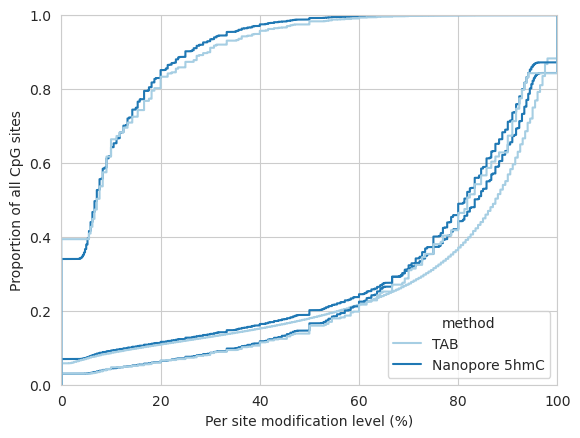

In [133]:
fig, ax = plt.subplots()

sns.set_palette("crest")

##### ax10 ##### 

# if not "two_mod_long" in locals():
#     two_mod_long = Checkpoint(path='./intermediates/two_mod_long.tsv').loadCheckpoint().replace("Bisulphite", "WGBS")

if not "mc_df_long" in locals():
    mc_df_long = Checkpoint(path='./intermediates/mc_df_long.tsv').loadCheckpoint().replace(["Bisulphite", "Nanopore"], ["oxBS", "Nanopore 5mC"])

if not "hmc_df_long" in locals():
    hmc_df_long = Checkpoint(path='./intermediates/hmc_df_long.tsv').loadCheckpoint().replace(["Bisulphite", "Nanopore"], ["TAB", "Nanopore 5hmC"])

# sns.ecdfplot(two_mod_long, x="percentMeth", hue="method", legend=True, ax=ax)
sns.ecdfplot(mc_df_long, x="percentMeth", hue="method", legend=True, ax=ax)
sns.ecdfplot(hmc_df_long, x="percentMeth", hue="method", legend=True, ax=ax)

ax.set_ylabel("Proportion of all CpG sites")
ax.set_xlabel("Per site modification level (%)")
ax.set_xlim([0, 100])
ax.set_ylim([0, 1])

fig.tight_layout()

## Figure 2

NameError: name 'featureAndGene' is not defined

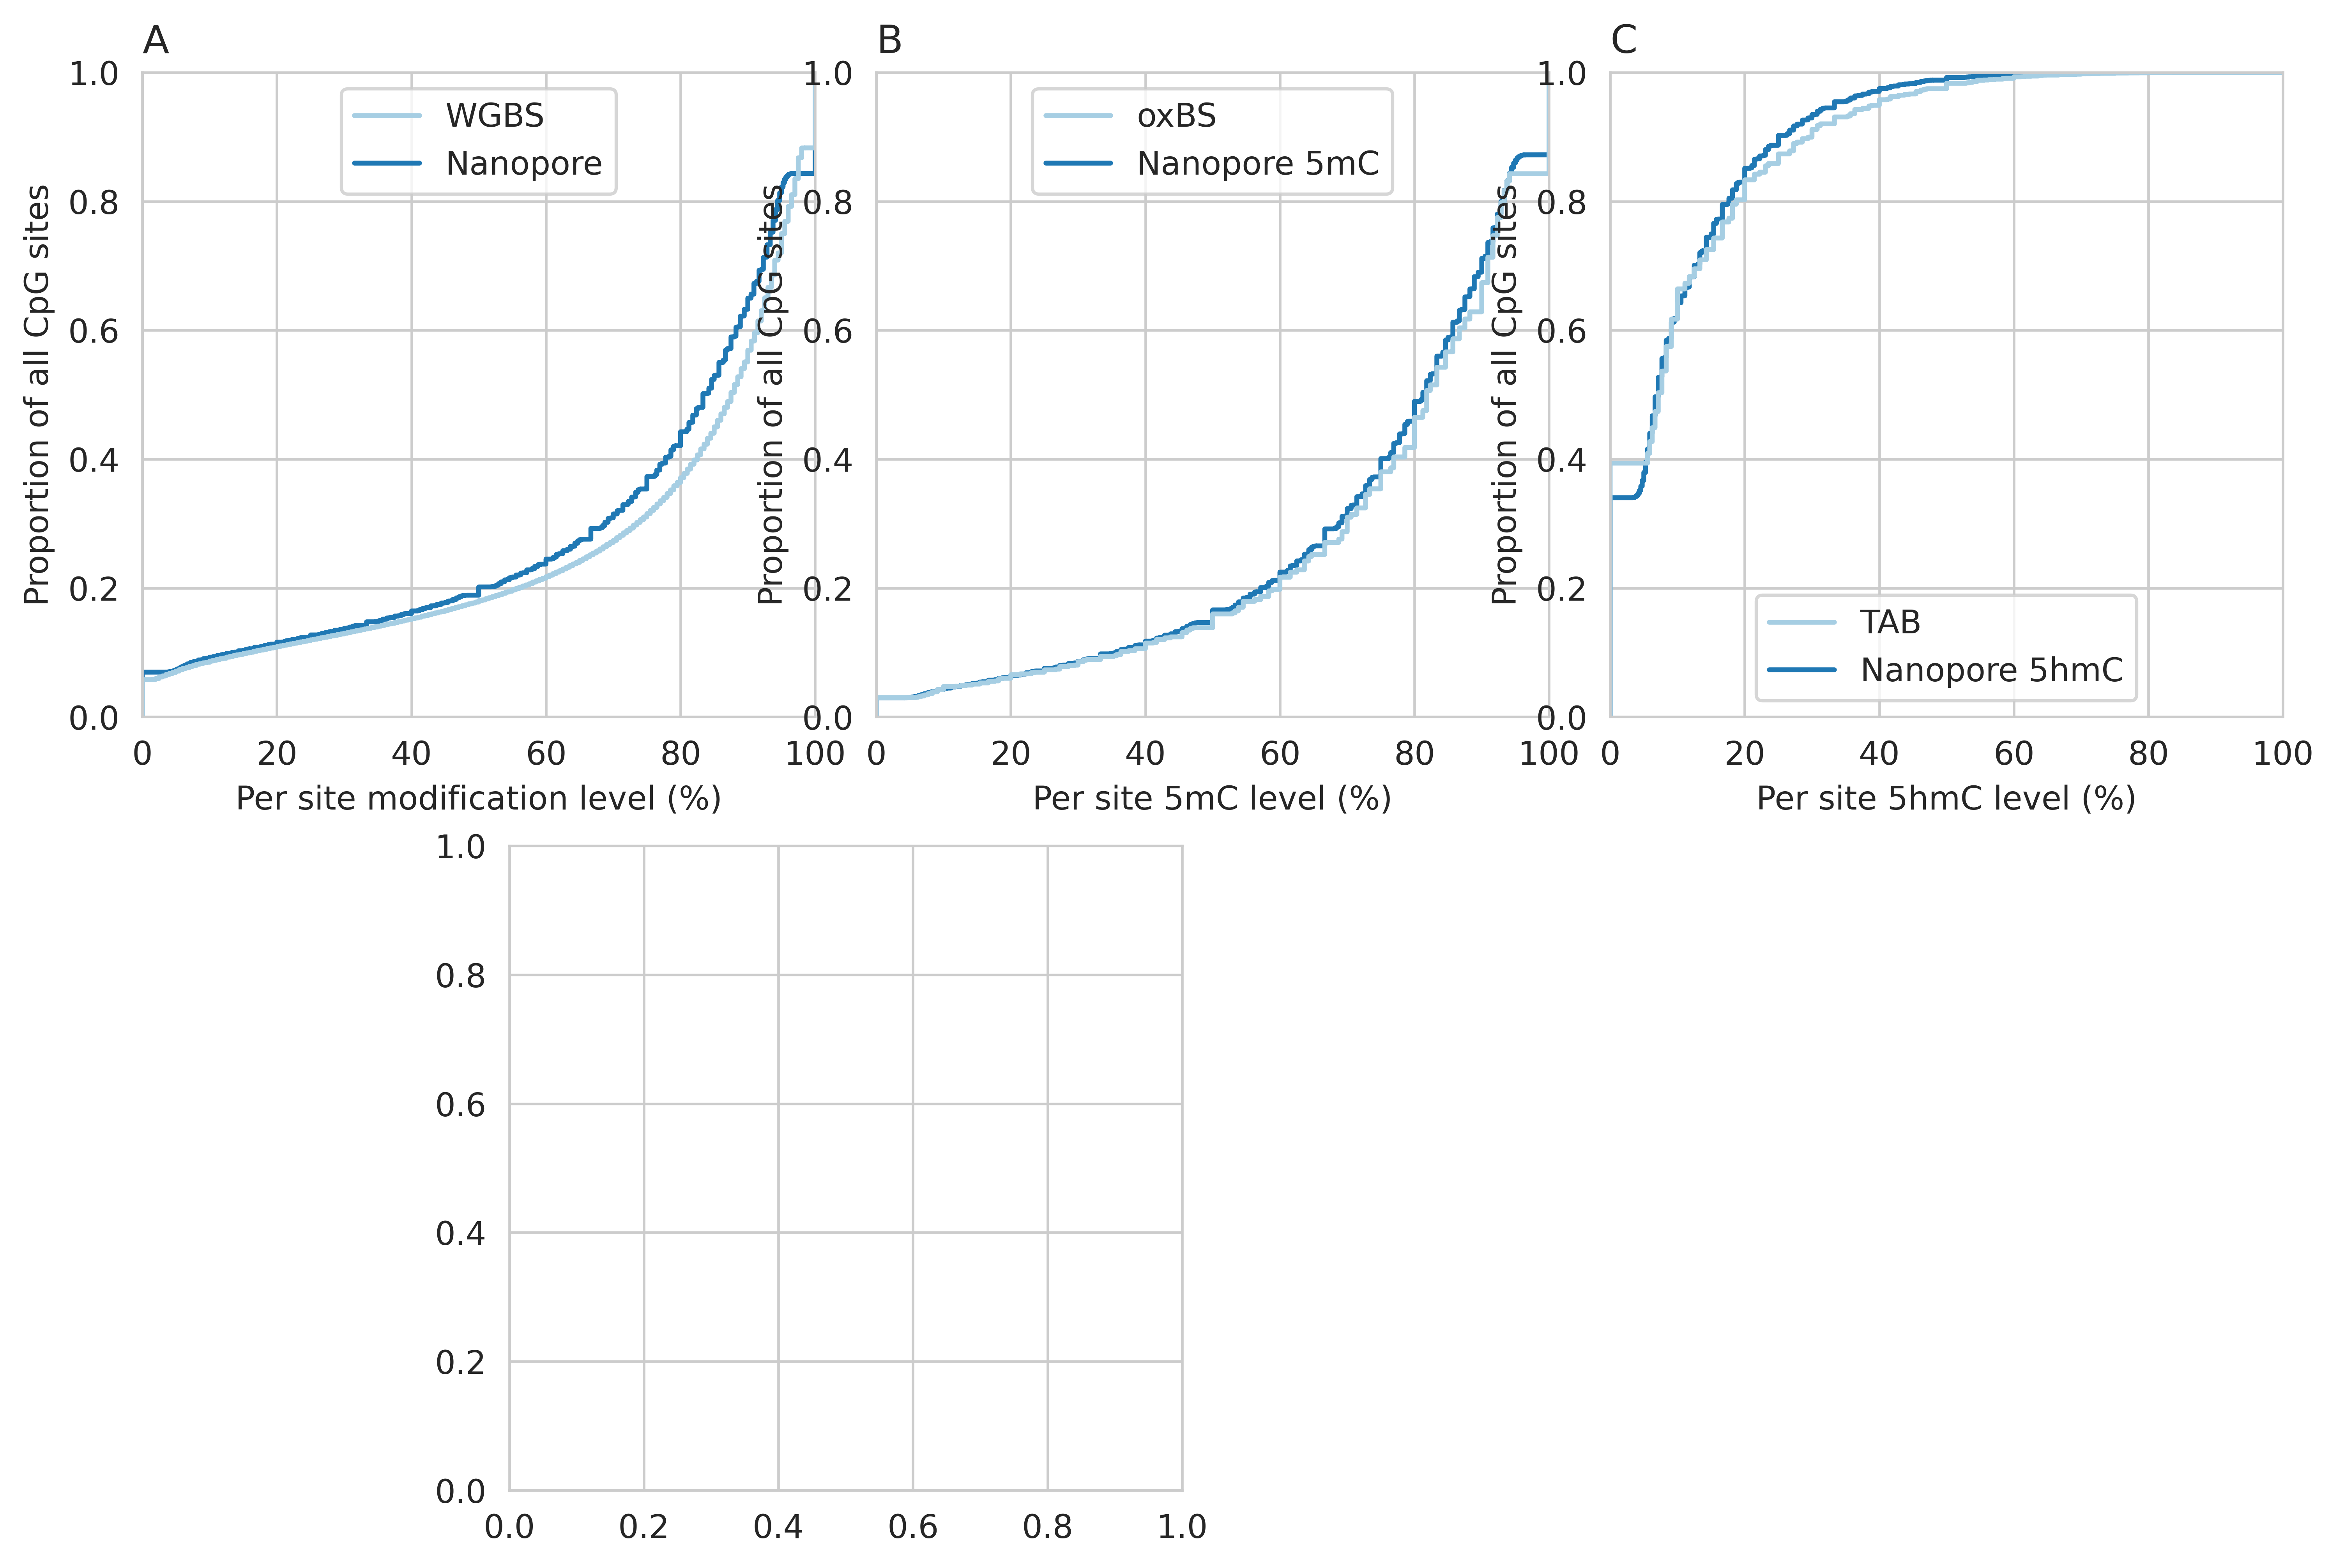

In [7]:
##### Figure 2 #####
sns.set_style("whitegrid")
sns.set_palette("Blues")

fig2 = plt.figure(figsize=((30)/2.54, (20)/2.54), dpi=600, facecolor="None")
gs2 = GridSpec(2, 6, fig2)

##### ax10 ##### 

ax200 = fig2.add_subplot(gs2[0, :2])

sns.ecdfplot(Checkpoint(path='./intermediates/two_mod_long.tsv').loadCheckpoint().replace("Bisulphite", "WGBS"), 
             x="percentMeth", hue="method", legend=True, palette="Paired", ax=ax200)
sns.move_legend(ax200, "upper center", title=None)
ax200.set_ylabel("Proportion of all CpG sites")
ax200.set_xlabel("Per site modification level (%)")
ax200.set_xlim([0, 100])
ax200.set_ylim([0, 1])
ax200.set_title("A", loc="left")

##### ax11 ##### 

ax11 = fig2.add_subplot(gs2[0, 2:4])

sns.ecdfplot(Checkpoint(path='./intermediates/mc_df_long.tsv').loadCheckpoint().replace(["Bisulphite", "Nanopore"], ["oxBS", "Nanopore 5mC"]), 
             x="percentMeth", hue="method", legend=True, palette="Paired", ax=ax11)
sns.move_legend(ax11, "upper center", title=None)
ax11.set_ylabel("Proportion of all CpG sites")
ax11.set_xlabel("Per site 5mC level (%)")
ax11.set_xlim([0, 100])
ax11.set_ylim([0, 1])
ax11.set_title("B", loc="left")

##### ax202 ##### 

ax202 = fig2.add_subplot(gs2[0, 4:])

sns.ecdfplot(Checkpoint(path='./intermediates/hmc_df_long.tsv').loadCheckpoint().replace(["Bisulphite", "Nanopore"], ["TAB", "Nanopore 5hmC"]), 
             x="percentMeth", hue="method", legend=True, palette="Paired", ax=ax202)
sns.move_legend(ax202, "lower center", title=None)
ax202.set_ylabel("Proportion of all CpG sites")
ax202.set_xlabel("Per site 5hmC level (%)")
ax202.set_xlim([0, 100])
ax202.set_ylim([0, 1])
ax202.set_title("C", loc="left")

##### Histogram shared #####

data = Checkpoint(path='./intermediates/three_mod_pyrange.tsv').loadCheckpoint()

##### ax220 #####

ax220 = fig2.add_subplot(gs2[1, 1:3])

gene_data = featureAndGene(CpGIntersects(data).group("genes"), 10)

gene_data.makeHist("count", ax220)
ax220.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")

gene_r, gene_p = gene_data.calcPearson()
gene_rho, gene_rhoP = gene_data.calcSpearman()

ax220.text(3-(5.5+3)/2, 3.3, "Pearson r = {r:.2f}".format(r=gene_r), ha="center")
ax220.text(3-(5.5+3)/2, 3.8, "Spearman \u03C1 = {rho:.2f}".format(rho=gene_rho), ha="center")
ax220.set_ylim((-5.5, 3))
ax220.set_xlim((-5.5, 3))
ax220.set_xlabel("TAB enrichment")
ax220.set_ylabel("Nanopore enrichment")
ax220.set_title("D", loc="left")

##### ax221 ##### 

ax221 = fig2.add_subplot(gs2[1, 3:5])

tile_data = tiledGroup(CpGIntersects(data).groupByGenomicWindow(300), 10)

tile_data.makeHist("density", ax=ax221)
ax221.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")

tile_r, tile_p = tile_data.calcPearson()
tile_rho, tile_p = tile_data.calcSpearman()

ax221.text(3-(5.5+3)/2, 3.3, "Pearson r = {r:.2f}".format(r=tile_r), ha="center")
ax221.text(3-(5.5+3)/2, 3.8, "Spearman \u03C1 = {rho:.2f}".format(rho=tile_rho), ha="center")
ax221.set_ylim((-5.5, 3))
ax221.set_xlim((-5.5, 3))
ax221.set_xlabel("TAB enrichment")
ax221.set_ylabel("Nanopore enrichment")
ax221.set_title("E", loc="left")

##### Outputs #####

fig2.set_tight_layout(True)
fig2.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure2.png')
fig2.tight_layout()

### Figure 2 Data Table
This data table highlights 300bp regions showing substantial hydroxymethylation in Nanopore or TAB, as well as regions enriched/depleted in both to act as controls. 

In [ ]:
data = Checkpoint(path='./intermediates/three_mod_pyrange.tsv').loadCheckpoint()

In [ ]:
all_tiles = tiledGroup(CpGIntersects(data).groupByGenomicWindow(300), 10)
all_tiles.exportTests(10)

In [ ]:
all_tiles.calcMannWhitney("less")

MannwhitneyuResult(statistic=27822203.0, pvalue=1.200434190068272e-13)

## Figure 3

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


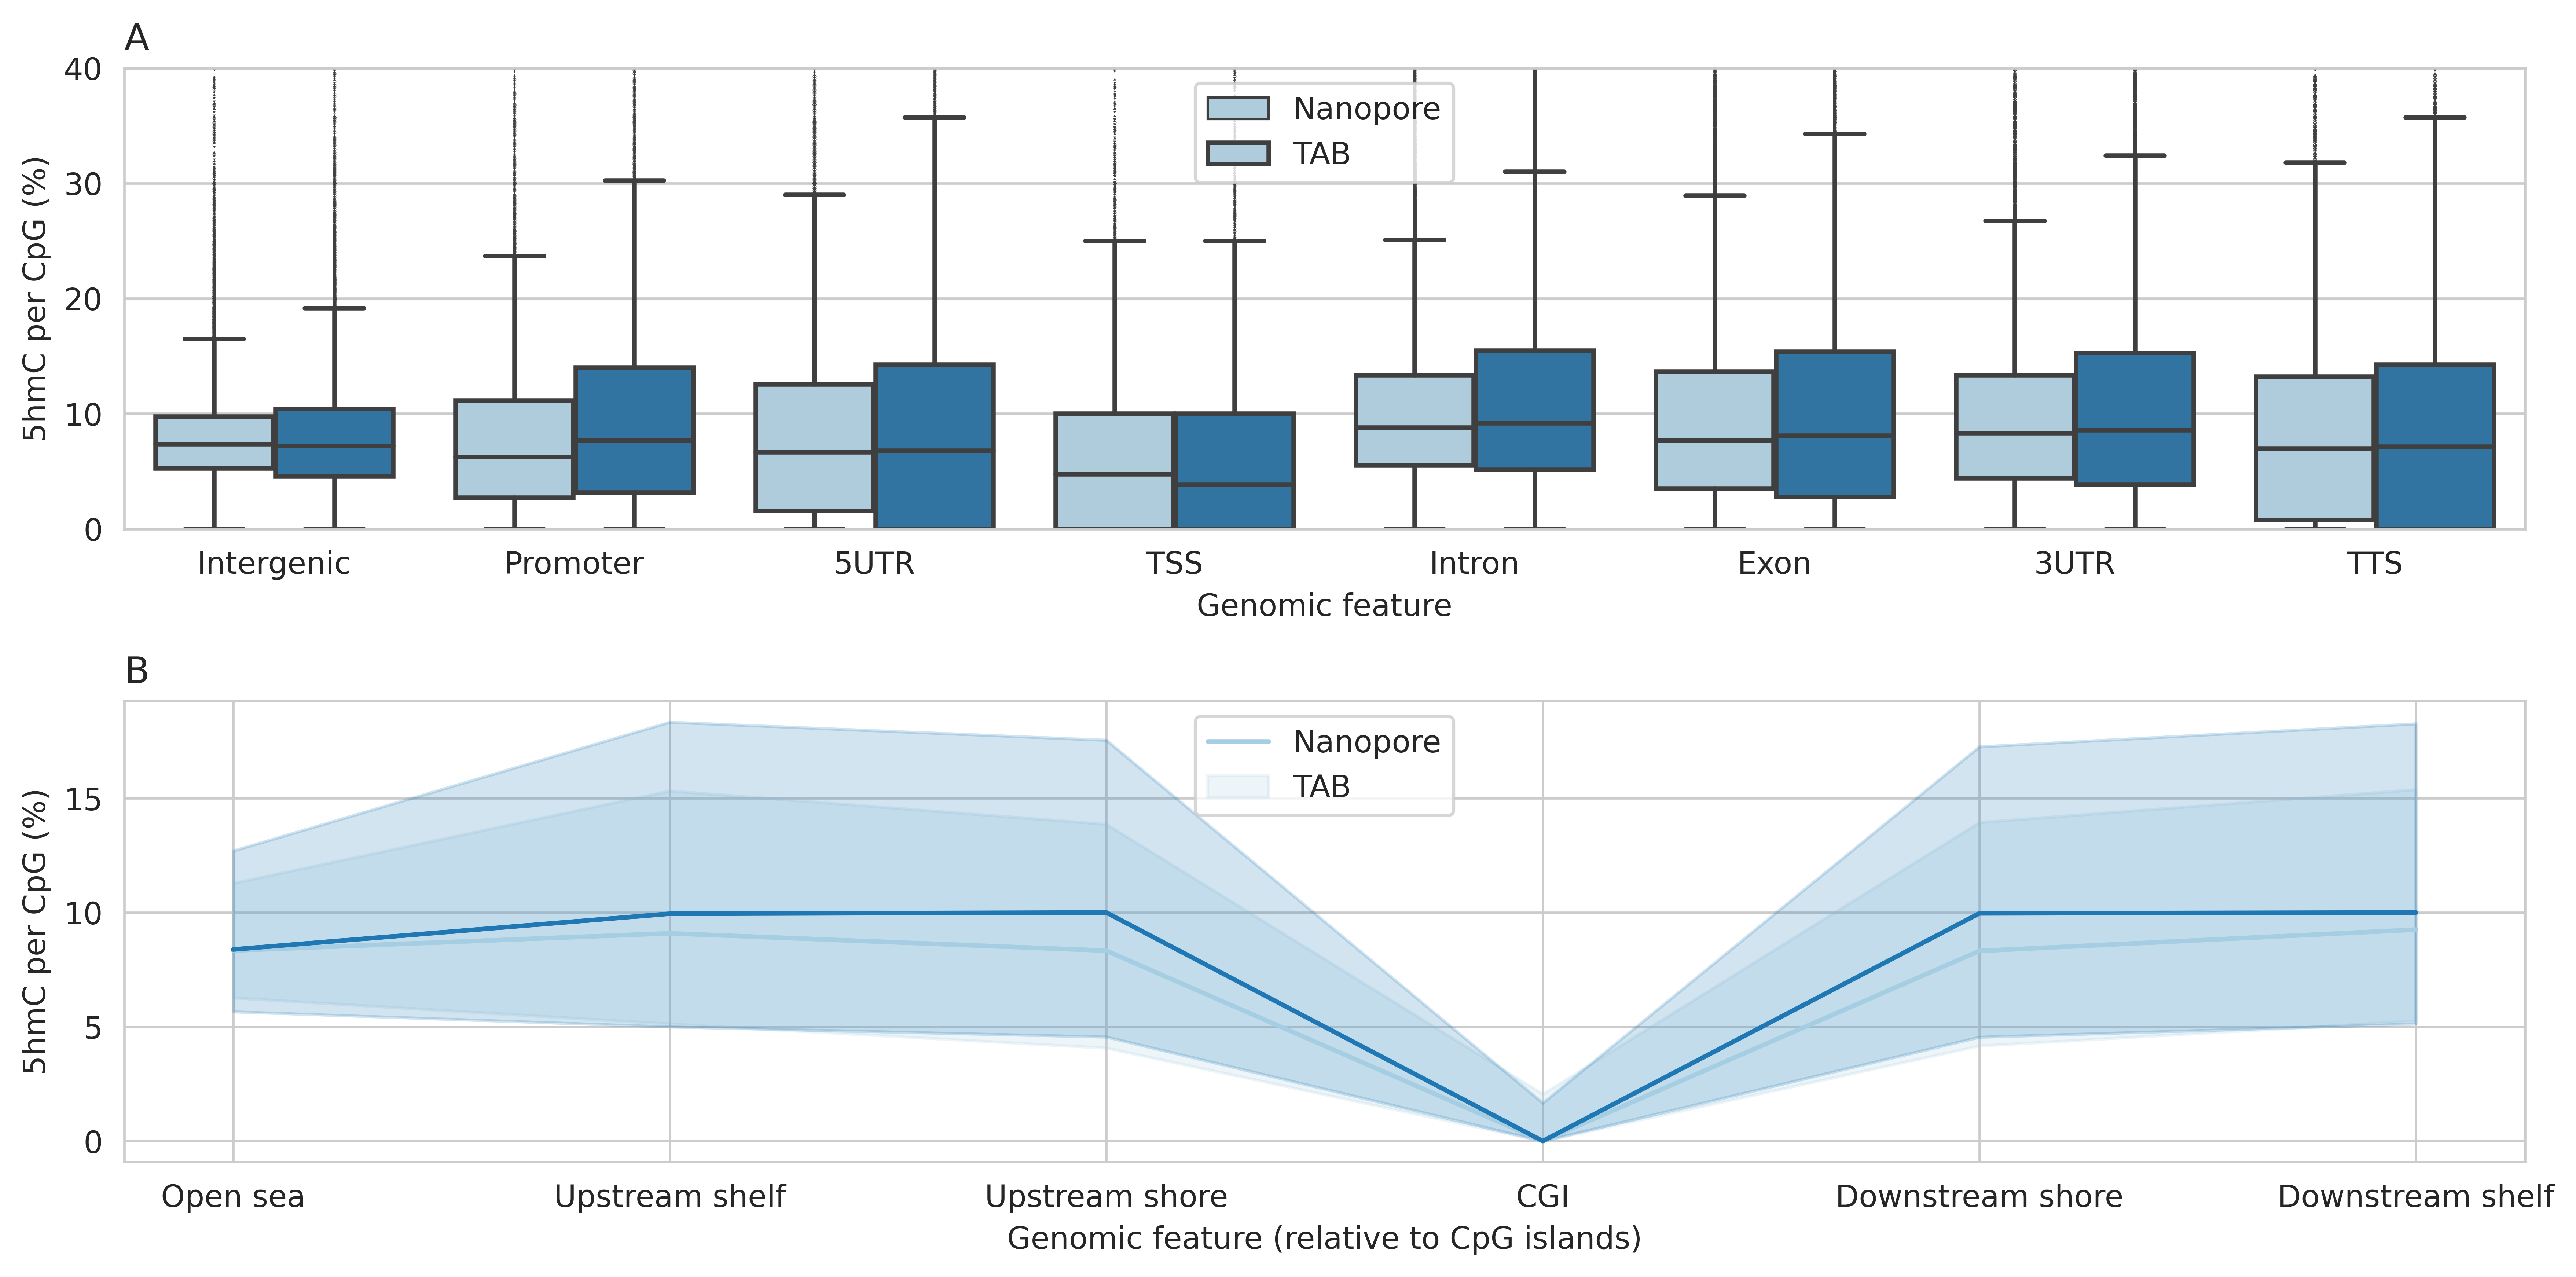

In [88]:
##### Figure 3 #####
sns.set_style("whitegrid")
sns.set_palette("Paired")

fig3 = plt.figure(figsize=((30/2.54), (15/2.54)), dpi=600)
gs3 = GridSpec(2, 1, fig3)

##### ax300 ##### 

ax300 = fig3.add_subplot(gs3[0, 0])

featureAndGene(CpGIntersects(data).group("features")).makeBoxplots(ax300)
sns.move_legend(ax300, "upper center", title=None, labels=["Nanopore", "TAB"])
ax300.set_title("A", loc="left")
ax300.set_ylim((0, 40))
ax300.set_ylabel("5hmC per CpG (%)")
ax300.set_xlabel("Genomic feature")

##### ax300 ##### 

ax310 = fig3.add_subplot(gs3[1, 0])

featureAndGene(CpGIntersects(data).group("CGI")).makeLineplot(ax310)
sns.move_legend(ax310, "upper center", title=None, labels=["Nanopore", "TAB"])
ax310.set_title("B", loc="left")
ax310.set_ylabel("5hmC per CpG (%)")
ax310.set_xlabel("Genomic feature (relative to CpG islands)")

##### Output #####

fig3.set_tight_layout(True)
fig3.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure3.png')
fig3.show()